# Working with Gaussians

## Estimating unobserved data
In this live script, we will be working with temperature data in Boston. We will use the concepts explored in this section to create estimates of unobserved data using Gaussian processes. 

### The Data (Avalilable in https://www.usclimatedata.com/)
Initially, lets load the data available for this example. We have two data sets

1. Weather information in Boston in the forms of averages from 1981 to 2010. We are provided with average high and low temperature precipitation and inches of snow for every day of the year.
2. Weather information in Boston in 2019. We are provided with average high and low temperature precipitation and inches of snow for every day of the year.

For simplicity we are going to work with the temperature information only.
The provided file 'data.mat' consis of 4 columns and 365 rows. Each row indicates a consecutuve day of the year. 
- Column 1 is the highest recorded temperature in Boston in 2019 in a particular day.
- Column 2 is the lowest recorded temperature in Boston in 2019 in a particular day.
- Column 3 is the average of the highest recorded temperatures in Boston from 1981 to 2010 in a particular day.
- Column 4 is the average of the lowest recorded temperature in Boston from 1981 to 2010 in a particular day.

Load the average data

In [2]:
import scipy.io
!wget https://github.com/maxoboe/6419_recitations/blob/main/data/data.mat?raw=true
# rename the file
!mv data.mat\?raw\=true data.mat
# Load the data
d = scipy.io.loadmat('data.mat')
# d = scipy.io.loadmat("https://github.com/maxoboe/6419_recitations/blob/a6d75839e884fa066dbf66b0c95e2ee3ffcc9886/data/data.mat")
data = d['data'].T

--2021-12-06 23:52:27--  https://github.com/maxoboe/6419_recitations/blob/main/data/data.mat?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/maxoboe/6419_recitations/raw/main/data/data.mat [following]
--2021-12-06 23:52:27--  https://github.com/maxoboe/6419_recitations/raw/main/data/data.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maxoboe/6419_recitations/main/data/data.mat [following]
--2021-12-06 23:52:28--  https://raw.githubusercontent.com/maxoboe/6419_recitations/main/data/data.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awa

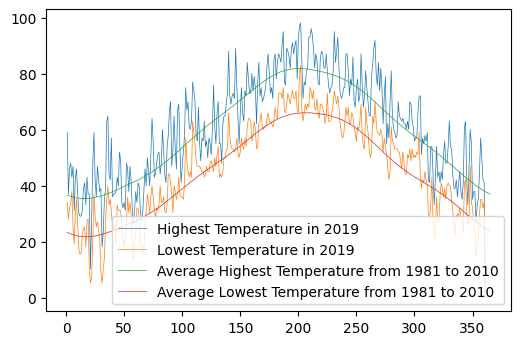

In [3]:
# Visualize the data:
import numpy as  np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100

x = np.arange(1, 366)
for i, label in enumerate([
                           "Highest Temperature in 2019",
                           "Lowest Temperature in 2019",
                           "Average Highest Temperature from 1981 to 2010",
                           "Average Lowest Temperature from 1981 to 2010"
                          ]):
  plt.plot(x, data[i], label=label, lw=0.5)
plt.legend()
plt.show()

**Note: Temperature information is missing for the last 5 days of 2019. Entries have been filled with zeros, but this does not mean the temperature is zero.**

### Partition the observed data for cross validation

We will use the described cross validaton process. Where we are going to partition the available observations $\mathbf{x}_2$ into $\kappa$ partitions. For simplicity lets initially pick $\kappa=2$ that is, we partition $\mathbf{x}_2$  into two groups.

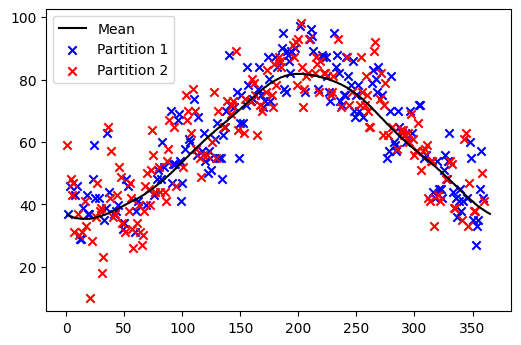

In [4]:
ind_x2 = np.arange(0,360,1)
perm = np.random.permutation(ind_x2.shape[0])
idx_train, idx_test = [ ind_x2[a] for a in map(np.sort, np.split(perm, 2)) ]
y_train = data[0][idx_train]
y_test = data[0][idx_test]
mean_train = data[2][idx_train]
mean_test = data[2][idx_test]
for k_x2, label, c in [(idx_train, "Partition 1", 'b'), (idx_test, "Partition 2", 'r')]:
  plt.scatter(k_x2+1, data[0][k_x2], label=label, c=c, marker='x')

x = np.arange(1,366)
plt.plot(x, data[2], c='k', label="Mean")
plt.legend()
plt.show()

## Predicting with Tools from This Course
First, use the tools from earlier in this course to predict the missing values by fitting any periodic or polynomial patterns in the data. Report the test-set MSE from this attempt. 

You may find the solutions from the climate module helpful: https://colab.research.google.com/drive/1vJmoFJu0rSKdLZOqinD6Czr1vrVaEAIl?usp=sharing 

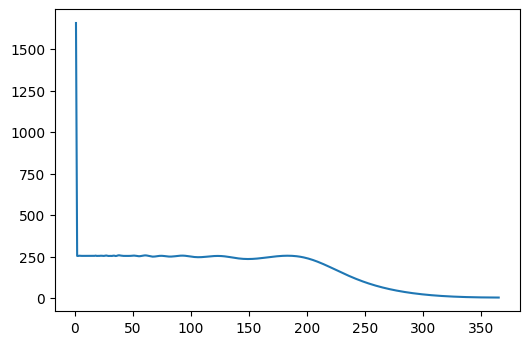

minimizing period is: 365


In [5]:
## TODO: form predictions of the output values, using your existing toolbox.
from scipy import optimize
period_range = np.arange(1, 366)
mse_list = []

def find_sine_approximation(period, x_data, y_data):
  """
  Finds a best-fitting sinusoidal approximation, for the given frequency. 
  """
  def sine_function(X, amp, phase_shift, mean):
    return (amp * np.sin(1/period * 2 * np.pi * (X - phase_shift)) + mean)
  params, _ = sine_curve_fit = optimize.curve_fit(
    f = sine_function,
    xdata = x_data.flatten(),
    ydata = y_data.flatten(),
    p0 = np.array([3, 1, 0]))
  amp, phase_shift, mean = params
  sin_prediction = sine_function(x_data, amp, phase_shift, mean)
  return sin_prediction
for period in period_range:
  sin_prediction = find_sine_approximation(period, np.arange(1,366), data[0])
  mse = np.nanmean((data[2] - sin_prediction) **2)
  mse_list.append(mse)
plt.plot(period_range, mse_list);
plt.show()
period_guess = period_range[np.argmin(mse_list)]
print("minimizing period is:", period_guess)

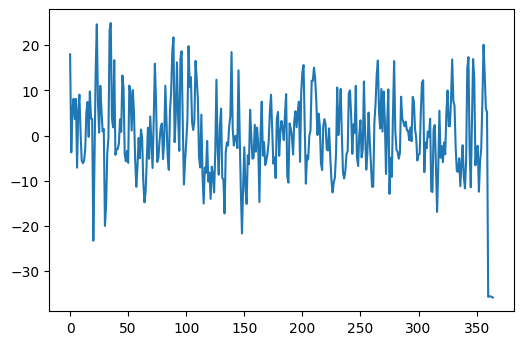

In [6]:
sin_prediction_1 = find_sine_approximation(365, np.arange(1,366), data[0])
sin_prediction_2 = find_sine_approximation(38, np.arange(1,366), data[0] - sin_prediction_1)
sin_residuals = data[0] - sin_prediction_1 - sin_prediction_2
plt.plot(sin_residuals)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


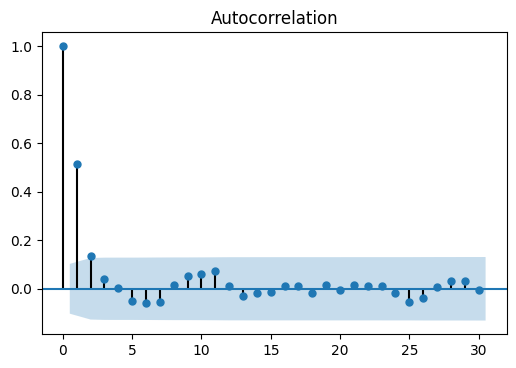

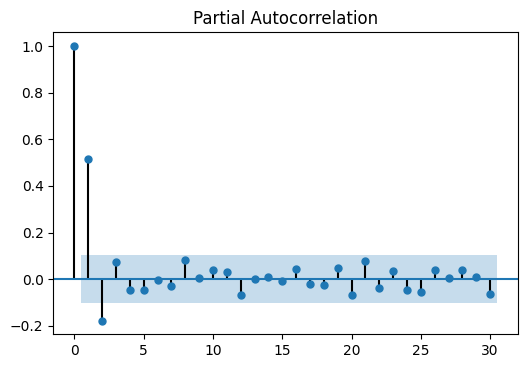

In [7]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(sin_residuals, lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(sin_residuals, lags=30)
plt.show()

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


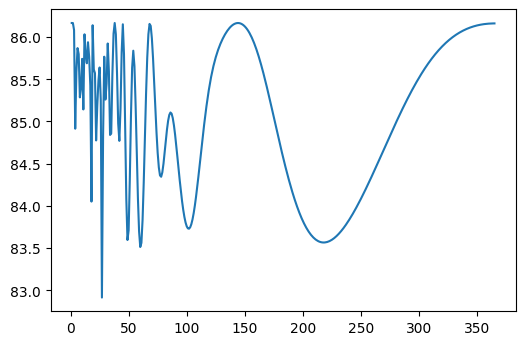

minimizing period is: 27


In [8]:
mse_list = []
def find_sine_approximation(period, x_data, y_data):
  """
  Finds a best-fitting sinusoidal approximation, for the given frequency. 
  """
  def sine_function(X, amp, phase_shift, mean):
    return (amp * np.sin(1/period * 2 * np.pi * (X - phase_shift)) + mean)
  params, _ = sine_curve_fit = optimize.curve_fit(
    f = sine_function,
    xdata = x_data.flatten(),
    ydata = y_data.flatten(),
    p0 = np.array([3, 1, 0]))
  amp, phase_shift, mean = params
  sin_prediction = sine_function(x_data, amp, phase_shift, mean)
  return sin_prediction
for period in period_range:
  sin_prediction_2 = find_sine_approximation(period, np.arange(1,366), sin_residuals)
  mse = np.nanmean((sin_residuals - sin_prediction_2) **2)
  mse_list.append(mse)
plt.plot(period_range, mse_list);
plt.show()
period_guess = period_range[np.argmin(mse_list)]
print("minimizing period is:", period_guess)

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1272.054
Date:                Mon, 06 Dec 2021   AIC                           2548.108
Time:                        23:52:31   BIC                           2555.908
Sample:                             0   HQIC                          2551.208
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5391      0.037     14.582      0.000       0.467       0.612
sigma2        62.2617      3.633     17.139      0.000      55.141      69.382
Ljung-Box (Q):                       33.21   Jarque-

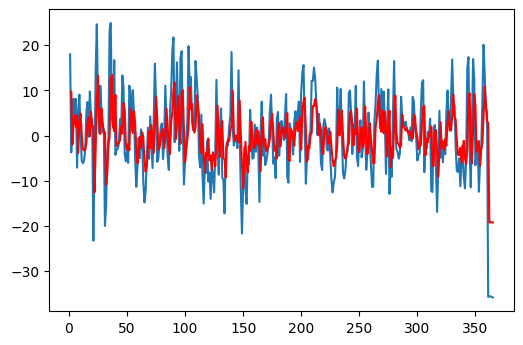

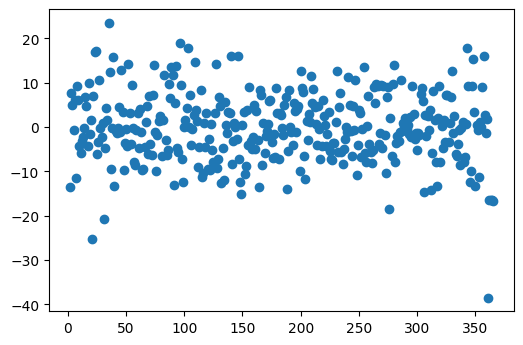

MSE with AR 1 model, after accounting for trend: 61.80283930443158


In [9]:
import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
ar_1 = SARIMAX(sin_residuals, order=(1, 0, 0)).fit()
print(ar_1.summary())
ar_1_predictions = ar_1.predict()
ar_1_residuals = sin_residuals.reshape(-1,1) - ar_1_predictions.reshape(-1,1)
ar_1_residuals = ar_1_residuals[1:] # Fitting AR 1 model means removing one observation
plt.plot(np.arange(1,366), sin_residuals, label='original data')
plt.plot(np.arange(2,366), ar_1_predictions[1:], 'r', label='fitted line')
plt.show()
plt.plot(np.arange(2,366), ar_1_residuals, 'o')
plt.show()
print("MSE with AR 1 model, after accounting for trend:", np.mean(ar_1_residuals**2))

## Predicting with Gaussians
Now, predict the missing values using the assumption of Gaussianity and the covariance of the full series as a function of distance. Report the MSE for this attempt. 


Note that you can use arbitrarily many points to form this prediction; to simplify the problem, consider only the 5 closest values.

### Step 1: Autocovariance
Find the autocovariance of temperature as a function of time steps, using the full dataset. 
You may find this reference helpful: https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.acovf.html 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:354: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


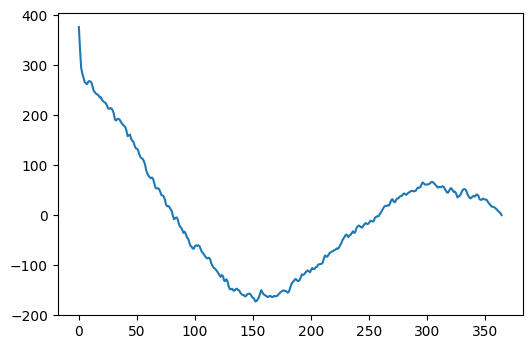

In [10]:
# TODO: add code to find the autocovariance as a function of distance. 
import statsmodels.tsa.api as smt
autocovariances = smt.stattools.acovf(data[0])
plt.plot(autocovariances)

### Step 2: Find closest 5 values for each point 
Find a function that returns the five closest values for each point. 

In [11]:
# this code does not need changing 
def closest_values_in_train(idx, num_vals = 5):
  """
  Finds the five closest values in the training dataset 
  to the given index from the test dataset.
  Returns both the index of those values and the distances. 
  """
  distances = np.abs(idx_train - idx)
  sorted_indexes = distances.argsort()
  closest_indexes = sorted_indexes[0:num_vals]
  closest_distances = distances[closest_indexes]
  return closest_indexes, closest_distances
closest_indexes, closest_distances = closest_values_in_train(76)
print(idx_train[closest_indexes], closest_distances)
print(data[0][76], y_train[closest_indexes])

[75 77 78 81 82] [1 1 2 5 6]
44.1 [43.  48.  51.1 48.  60.1]


### Step 3: Predict using Gaussian Distribution
Use the formula for conditional expectation of multivariate Gaussians to find the predicted value at each missing observation. 

As a refresher, the formula is: 
$
\mu_{\mathbf{X}_2^i | \mathbf{X}_2^{-i}} = \mu_2^i + \Sigma_{\mathbf{X}_2^i,\mathbf{X}_2^{-i}} \Sigma_{\mathbf{X}_2^{-i},\mathbf{X}_2^{-i}}^{-1} (\mathbf{x}_2^{-i} - \mu_2^{-i})
$


Note that $\mu_{2}^i$ can be found as the average temperature at the given date from the historical record, and that $\Sigma$ is the matrix of covariance between all observations you're conditioning on. 
In our data, note that `data[2]` gives the series of the average highest recorded temperature. 

In [12]:
# TODO: form these predictions 
# Suggestion: fill in these missing functions to predict for each observation, then loop over the data

# No need to change this block: computes the covariance matrix as a function of distance
# ----------------
# Should work as long as autocovar is a list of autocovariances of the test matrix 
distances = np.arange(1,366).reshape(-1,1) - np.arange(1,366).reshape(1,-1)
# Distances is a 365 x 365 matrix of predicted values, based on the distance 
acv_func = lambda x: autocovariances[np.abs(x)]
vfunc = np.vectorize(acv_func)
sigma = vfunc(distances)
# ----------------
def predict_for_one_index(idx, num_vals=10):
  # 𝜇𝑖2+Σ𝐗𝑖2,𝐗−𝑖2Σ−1𝐗−𝑖2,𝐗−𝑖2(𝐱−𝑖2−𝜇−𝑖2)
  closest_indexes, closest_distances = closest_values_in_train(idx, num_vals)
  predicted_value = data[2][idx] + \
        acv_func(closest_distances).reshape(1,-1) @ \
        np.linalg.pinv(sigma[closest_distances.reshape(1,-1) + 1, closest_distances.reshape(-1,1) + 1]) @ \
        (y_train[closest_indexes] - mean_train[closest_indexes]) 
  return predicted_value
print(predict_for_one_index(31, num_vals = 10))
print(predict_for_one_index(31, num_vals = 150))
print(data[0][31])

[41.79210499]
[35.13331954]
23.2


In [13]:
num_vals = 150
predictions = [predict_for_one_index(idx, num_vals) for idx in idx_test]
print("MSE from GP Predictions", 
      np.mean((np.array(predictions).reshape(-1,1) - y_test.reshape(-1,1))**2))

MSE from GP Predictions 55.700387402015316


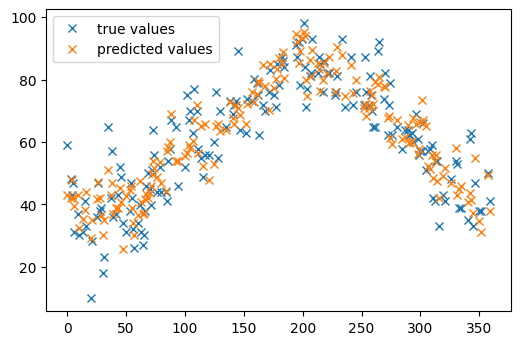

In [14]:
# plt.plot(np.arange(len(data[0])), data[0])
plt.plot(idx_test, y_test, 'x', label='true values')
plt.plot(idx_test, predictions, 'x', label='predicted values')
plt.gca().legend();

In [15]:
# Use the provided function to generate predictions
# Evaluate the performance of the provided function

## Predict using Kernel Function
Here, the framework is as in the above section; the only difference is that you will be filling in values from the covariance matrix with the provided kernel function. 

In [16]:
theta1 = 4.2 #@param {type:"slider", min:0.1, max:10, step:0.1}
theta2 = 0.4 #@param {type:"slider", min:0.1, max:10, step:0.1}

covs = np.arange(1,366).reshape(-1,1) - np.arange(1,366).reshape(1,-1)
def cov_function(x): 
  return theta1 * np.exp( - x**2 / theta2**2 )
sigma = theta1 * np.exp( - covs**2 / theta2**2 )
# Use the alternate sigma to repeat the steps above. 

In [17]:
def predict_for_one_index(idx, num_vals=10):
  # 𝜇𝑖2+Σ𝐗𝑖2,𝐗−𝑖2Σ−1𝐗−𝑖2,𝐗−𝑖2(𝐱−𝑖2−𝜇−𝑖2)
  closest_indexes, closest_distances = closest_values_in_train(idx, num_vals)
  predicted_value = data[2][idx] + \
        cov_function(closest_distances).reshape(1,-1) @ \
        np.linalg.pinv(sigma[closest_distances.reshape(1,-1) + 1, closest_distances.reshape(-1,1) + 1]) @ \
        (y_train[closest_indexes] - mean_train[closest_indexes]) 
  return predicted_value
print(predict_for_one_index(31, num_vals = 1))
print(predict_for_one_index(31, num_vals = 10))
print(data[0][31])
num_vals = 10
predictions = [predict_for_one_index(idx, num_vals) for idx in idx_test]
print("MSE from GP Predictions", 
      np.mean((np.array(predictions).reshape(-1,1) - y_test.reshape(-1,1))**2))

[36.59691127]
[36.59690325]
23.2
MSE from GP Predictions 80.5325758838021


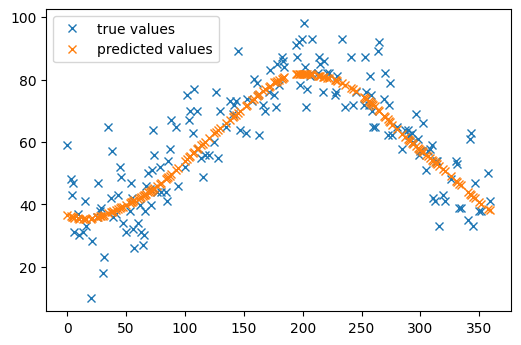

In [18]:
plt.plot(idx_test, y_test, 'x', label='true values')
plt.plot(idx_test, predictions, 'x', label='predicted values')
plt.gca().legend();

### Vary the number of neighbors the model uses in forming predictions. Do you see an improvement in predictions? Why or why not? 

In [19]:
# Add code to vary the number of neighbors used in forming predictions, and report the change to prediction accuracy 

### Vary the model parameters ($\theta_1;\  \theta_2$). Do you ever find a combination that improves over using the ACF? Over using the AR model? 

In [20]:
# Add code to vary the model parameters, and report about the optimal range you've found. 

{'kernel': RBF(length_scale=1e+04) + WhiteKernel(noise_level=0.1)}


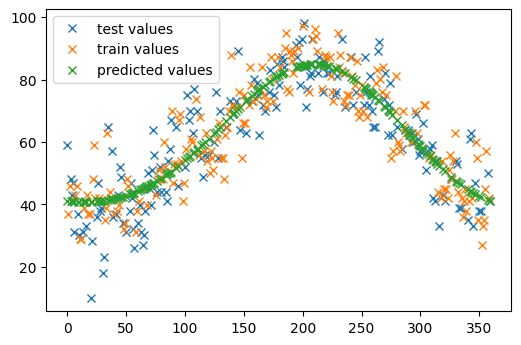

In [36]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RBF, ConstantKernel as C, DotProduct
gp_kernel = RBF(0.1) + WhiteKernel(1e-1)
gpr = GaussianProcessRegressor(normalize_y=True)
from sklearn.model_selection import GridSearchCV
param_grid = [{
    "kernel": [RBF(l) + WhiteKernel(1e-1) for l in np.logspace(-4, 4, 20)]
}] 
clf = GridSearchCV(estimator=gpr, param_grid=param_grid, cv=4,
                       scoring='r2')
clf.fit(idx_train.reshape(-1, 1), y_train)
print(clf.best_params_)
predictions = clf.predict(idx_test.reshape(-1,1))
# gpr.fit(idx_train.reshape(-1, 1), y_train.reshape(-1, 1))
# predictions = gpr.predict(idx_test.reshape(-1, 1))
plt.plot(idx_test, y_test, 'x', label='test values')
plt.plot(idx_train, y_train, 'x', label='train values')
plt.plot(idx_test, predictions, 'x', label='predicted values')
plt.gca().legend();

In [35]:
clf.best_params_

{'kernel': RBF(length_scale=1e+04) + WhiteKernel(noise_level=0.1)}

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
4 fits failed out of a total of 16.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------

{'alpha': 1.0, 'kernel': DotProduct(sigma_0=0.0001)}


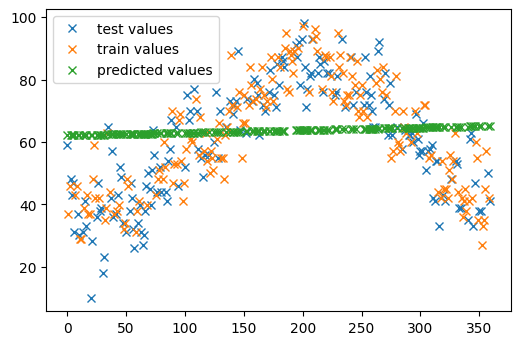

In [38]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RBF, ConstantKernel as C, DotProduct
gp_kernel = ExpSineSquared(40.0, 50.0, periodicity_bounds=(1e-2, 1e3)) + WhiteKernel(1e-1)
gpr = GaussianProcessRegressor(normalize_y=True)
from sklearn.model_selection import GridSearchCV
param_grid = [{
    "alpha":  np.logspace(-8, 0, 2),
    "kernel": [DotProduct(sigma_0) for sigma_0 in np.logspace(-4, 4, 2)]
}]
clf = GridSearchCV(estimator=gpr, param_grid=param_grid, cv=4,
                       scoring='r2')
clf.fit(idx_train.reshape(-1, 1), y_train)
print(clf.best_params_)
predictions = clf.predict(idx_test.reshape(-1,1))
# gpr.fit(idx_train.reshape(-1, 1), y_train.reshape(-1, 1))
# predictions = gpr.predict(idx_test.reshape(-1, 1))
plt.plot(idx_test, y_test, 'x', label='test values')
plt.plot(idx_train, y_train, 'x', label='train values')
plt.plot(idx_test, predictions, 'x', label='predicted values')
plt.gca().legend();

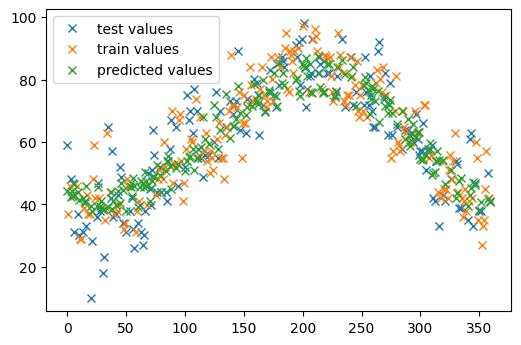

In [39]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RBF, ConstantKernel as C, DotProduct
gp_kernel = ExpSineSquared(0.1, 10.0) + WhiteKernel(1e-1)
gpr = GaussianProcessRegressor(kernel=gp_kernel, normalize_y=True)
gpr.fit(idx_train.reshape(-1, 1), y_train.reshape(-1, 1))
predictions = gpr.predict(idx_test.reshape(-1, 1))
plt.plot(idx_test, y_test, 'x', label='test values')
plt.plot(idx_train, y_train, 'x', label='train values')
plt.plot(idx_test, predictions, 'x', label='predicted values')
plt.gca().legend();
plt.show();